# Parcial 1


In [35]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm
import sympy as sym 
import random as rand
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import qexpy as q
from scipy import integrate

### 3.

In [211]:
class Particle:
    
    def __init__(self, r0, v0, a0,g0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        self.g=g0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        
        self.f = self.m*self.a
        self.fg=self.m*self.g
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        self.G=np.zeros_like(self.R)
        self.P = np.zeros_like(self.R)
    
        # Fisica
        self.K = 20.
        self.sigma = 1.5*self.radius
        
        self.epsilon = 1500
        self.VEk = np.zeros(len(t))
        self.Ep = 0.
        self.VEp = np.zeros(len(t))
        
        
        
        
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        
        self.a = self.f/self.m
        self.ag =self.fg/self.m
        
        # Euler
  #      self.r += self.dt*self.v
  #      self.v += self.dt*self.a
        
        # Euler-Cromer
        self.v += self.dt*self.ag
        self.r += self.dt*self.v
        self.SetPotentialEnergy(i)
        
    def CalculateForce(self,p):
        
        d = np.linalg.norm(self.r - p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            
            Fn = self.K * compresion**3
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n)
            # Falta implementar energía potencial 
            self.Ep += (self.K/4)*(compresion**4)
        
            
     
    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
        #self.g[:]= 0.
        self.Ep = 0.
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
        self.VEp[i]=self.Ep
        self.F[i]=self.fg
    def SetPotentialEnergy(self,i):
        self.VEp[i] = self.Ep
    
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale] 
    def GetPotential(self,scale=1):
        return self.U[::scale]
    
    def GetPotentialEnergy(self,scale=1):
        return self.VEp[::scale]
    def GetForce(self,scale=1):
        return self.F[::scale]
    
    # Debes agregar las paredes en este punto
    def CheckLimits(self):
        
        for i in range(2):
            
            if self.r[i] + self.radius > 20 and self.v[i] > 0.:
                self.v[i] = -self.v[i]*0.9
                
            elif self.r[i] - self.radius < -20 and self.v[i] < 0.:
                self.v[i] = -self.v[i]*0.9

In [212]:
def GetParticles(N,t):
    
    r0 = np.array([-15.,-10.])
    v0 = np.array([2.,0])
    a0 = np.array([0.,0.])
    g0=np.array([0.,-10.])

    
    p0 = Particle(r0,v0,a0,g0,t,m=1,radius=2,Id=0)

 
    
    # Aca deber agregar una rutina montecarlo para crear particulas
    # sobre el plano con velocidades aleatorias.
    
    return [p0]

In [213]:
dt = 0.001
tmax = 30
t = np.arange(0,tmax,dt)
Particles = GetParticles(1,t)

In [214]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckLimits()
            # Aca debes agregar la interaccion con la pared
            
            
    return Particles

In [215]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|██████████| 30000/30000 [00:00<00:00, 47898.92 Steps/s]


In [216]:
# Bajamos dimensión de la simulacion
scale = 400
t1 = t[::scale]

<IPython.core.display.Javascript object>


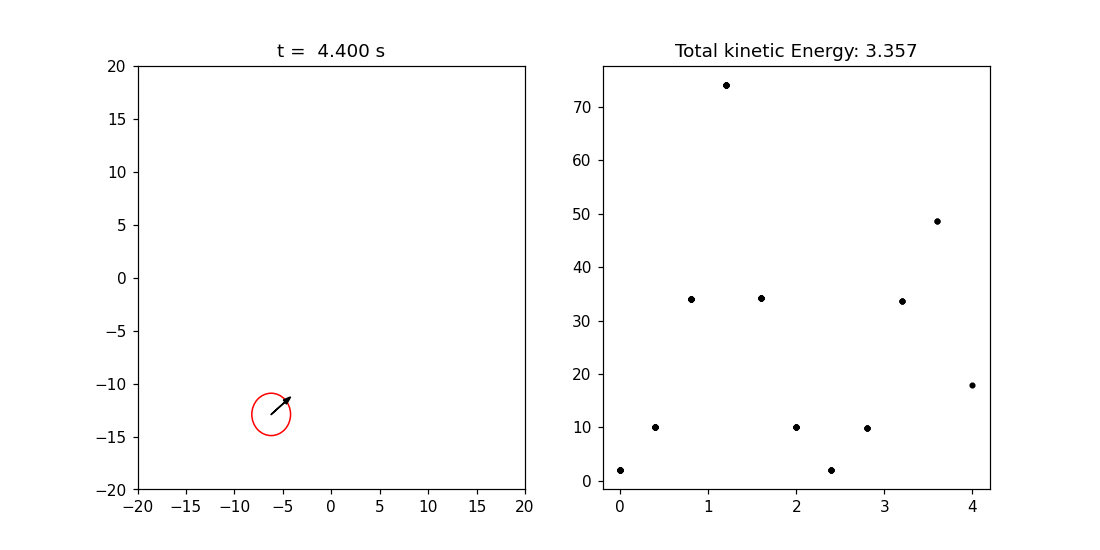

In [217]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        
        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

a)



b)
A partir de la simulación, es posible detectar que la pelota para de rebotar aproximadamente a los 23segundos.

c)

In [190]:
MomentumT = Particles[0].GetMomentum(scale)


In [191]:
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))


<IPython.core.display.Javascript object>


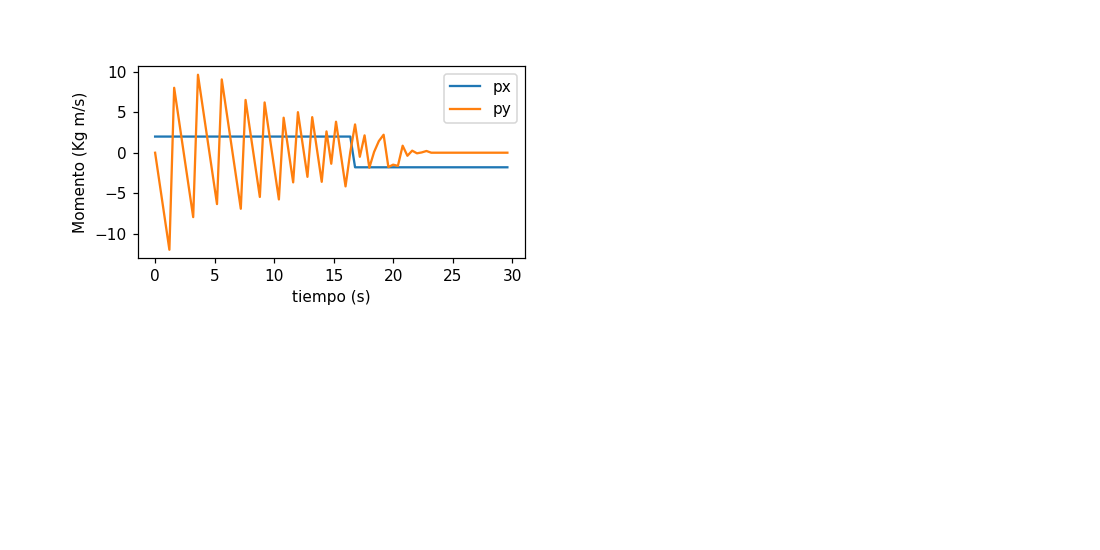

Text(0, 0.5, 'Momento (Kg m/s)')

In [192]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(221)
ax3.plot(t1,MomentumT[:,0],label='px')
ax3.plot(t1,MomentumT[:,1],label='py')
ax3.legend()
plt.xlabel("tiempo (s)")
plt.ylabel("Momento (Kg m/s)")

In [187]:
KineticT = Particles[0].GetKineticEnergy(scale)
EnergyP = Particles[0].GetPotentialEnergy(scale)

In [188]:
for i in range(1,len(Particles)):
    KineticT = np.add(KineticT,Particles[i].GetKineticEnergy(scale))
for i in range(1,len(Particles)):
    EnergyP = np.add(EnergyP,Particles[i].GetPotentialEnergy(scale))


<IPython.core.display.Javascript object>


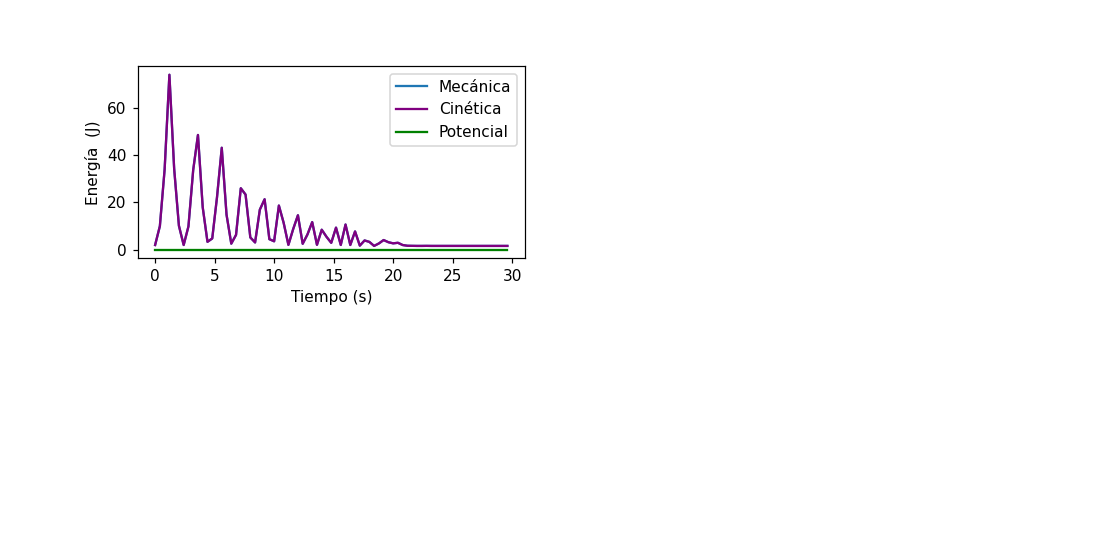

In [189]:
fig6 = plt.figure(figsize=(10,5))
ax6 = fig6.add_subplot(221)
plt.plot(t1,KineticT+0.5*EnergyP,label="Mecánica")
plt.plot(t1,KineticT,color="purple",label="Cinética")
plt.plot(t1,0.5*EnergyP,color="green",label="Potencial")
plt.xlabel("Tiempo (s)")
plt.ylabel("Energía  (J)")
plt.legend()

In [198]:

L=np.cross(Particles[0].GetPosition(scale),Particles[0].GetMomentum(scale))


for i in range(1,len(Particles)):
    L_i=np.cross(Particles[i].GetPosition(scale),Particles[i].GetMomentum(scale))
    L = np.add(L_i)
 

<IPython.core.display.Javascript object>


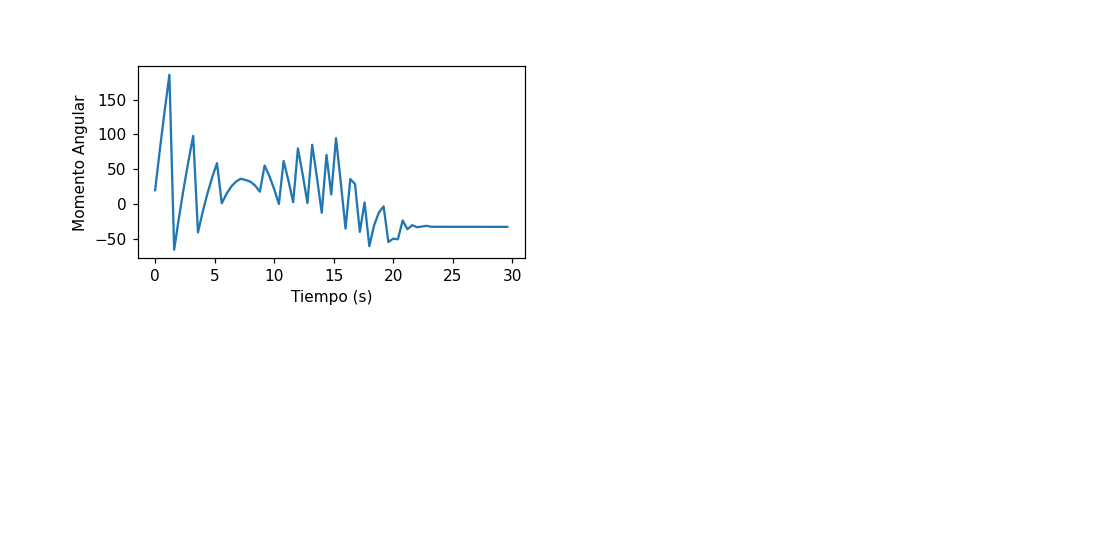

Text(0, 0.5, 'Momento Angular')

In [200]:
fig7 = plt.figure(figsize=(10,5))
ax7 = fig7.add_subplot(221)
ax7.plot(t1,L)

plt.xlabel("Tiempo (s)")
plt.ylabel("Momento Angular")


In [218]:
ForceT = Particles[0].GetForce(scale)


In [219]:
for i in range(1,len(Particles)):
    ForceT = np.add(ForceT,Particles[i].GetForce(scale))


<IPython.core.display.Javascript object>


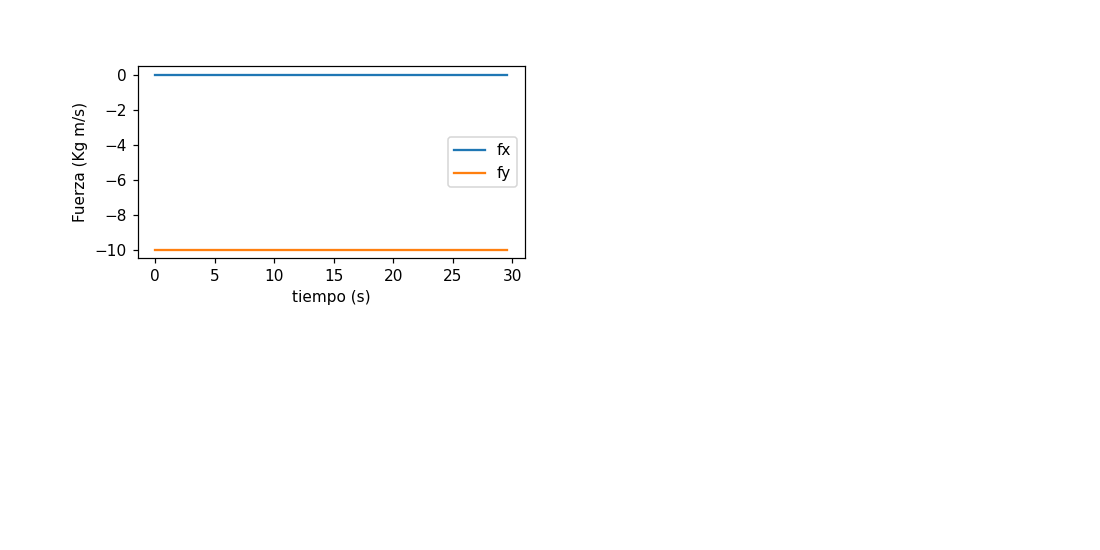

Text(0, 0.5, 'Fuerza (Kg m/s)')

In [220]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(221)
ax3.plot(t1,ForceT[:,0],label='fx')
ax3.plot(t1,ForceT[:,1],label='fy')
ax3.legend()
plt.xlabel("tiempo (s)")
plt.ylabel("Fuerza (Kg m/s)")

### 4.

a)

Partiendo de la segunda ley de newton la cual nos dice que:
$\sum F=ma$

Si hacemos un diagrama de cuerpo libre, podemos encontrar que en x no existen fuerzas, por ende,

$\sum F_x=0$

Para Y se encuentra que las fuerzas que actuan son la normal debida al suelo y el peso, por ende la sumatoria toma la forma:

$N-mg=m\frac{d^2x}{dy^2}$

A partir de esto y partiendo que la aceleracion es la segunda derivada de la posicion, se llega a que:

b)
Aplicando la segunda ley de Newton para dinámica rotacional se tiene que:
$$
\sum \tau= I\theta''
$$

De modo qque dado que el eje de rotación se encuentra a L/2 del centro de masa, este ejercería torque, dado pro la siguiente expresión:

$$
mg*\frac{L}{2}=I\theta''
$$

c)

d)

In [ ]:
g=9.81
h=0.01
t=np.arange(0,6+h,h)
def Ecuacion(theta,L,g=10):

In [221]:
def Integrator2(f,r0,t,L):
    
    h = t[1] - t[0]
    print(h)
    
    theta = np.zeros_like(t)
    dtheta = np.zeros_like(t)
    
    theta[0] = r0[0]
    dtheta[0] = r0[1]
    
    
    K1 = np.zeros(4)
  
    
    # Las pendientes instantaneas
    R = np.zeros(4)

    for i in range(1,len(t)):
        
        R = np.array([theta[i-1],dtheta[i-1]])
        
        K1 = f(R,t[i-1],L)
        
        R = np.array([theta[i-1]+h*K1[0],dtheta[i-1]+h*K1[1]])
        
        K2 = f(R,t[i-1],L)
        
        theta[i] = theta[i-1] + 0.5*h*(K1[0]+K2[0])
        dtheta[i] = dtheta[i-1] + 0.5*h*(K1[1]+K2[1])
     
    return x,y,vx,vy

e)

In [ ]:
theta0 = 10*np.pi/180
r0 = [theta0,0.]
theta,dtheta = Integrator2(Ecuacion,r0,t,0.5)
x=np.cos(theta)
y=np.sin(theta)
plt.plot(x,y)

f)